# Import the Data

In [1]:
!pip install scikit-image

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd 
from PIL import Image 
from skimage.transform import resize
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split

In [18]:
# Load the images and some metadata  
img_dir = 'data/'
img_w, img_h, img_ch = 224, 224, 3
filenames = os.listdir(img_dir) # read in the names of the image files 
filenames = [x.split('.')[0] for x in filenames] # remove the .jpg extensions for joining later 
img_files_df = pd.DataFrame(filenames, columns = ['Individual Patch']) # create a pandas dataframe 
img_files_df.head() # print the first few values to see if they look right 

,Individual Patch
0,020-3_10
1,019-1948-5_6
2,013-1988-C2_6
3,020-3_4
4,013-1988-C1_10


In [19]:
# Load the labels 
labels_dir = 'labels.csv'
labels_df = pd.read_csv(labels_dir, usecols=['Individual Patch', 'Binary Outcome'])
labels_df.head() # print the first few to see if they look right 

,Individual Patch,Binary Outcome
0,001-2002-1_1,0.0
1,001-2002-1_2,0.0
2,001-2002-1_3,0.0
3,001-2002-1_4,0.0
4,001-2002-1_5,0.0


# Pre Process the Data

In [20]:
# let's make sure each data point has both a label and an image by taking the intersection of these data frames 
full_data_points = img_files_df.merge(labels_df, on='Individual Patch')

# keep track of the total number of full data points 
num_imgs, _ = full_data_points.shape

In [21]:
# Iterate over all the images in the directory and place them in a numpy array 
# with their corresponding labels 
imgs = np.zeros((img_w, img_h, img_ch, num_imgs))
labels = np.zeros((num_imgs, 2))
for i, img_file in enumerate(full_data_points['Individual Patch'].values): 
     
    if i % 100 == 0: # display progress
        print(i, 'out of', num_imgs, 'images processed')
        
    img = np.asarray(Image.open(img_dir + img_file + '.jpg'))
    imgs[:,:,:,i] = resize(img, (img_w, img_h, img_ch)) 
    label = labels_df['Binary Outcome'].iloc[i] 
    if label == 0: # creates a one hot encoding for the label 
        labels[i,:] = [1, 0]
    else: 
        labels[i,:] = [0, 1]

0 out of 904 images processed
100 out of 904 images processed
200 out of 904 images processed
300 out of 904 images processed
400 out of 904 images processed
500 out of 904 images processed
600 out of 904 images processed
700 out of 904 images processed
800 out of 904 images processed
900 out of 904 images processed


# Explore the Data

[0. 1.]


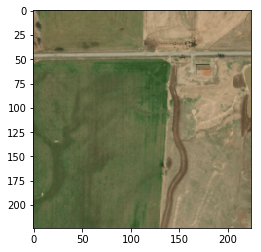

In [7]:
# Let's look at just a sample image and it's label 
sample = 6
print(labels[sample,:])
plt.imshow(imgs[:,:,:,sample]) 

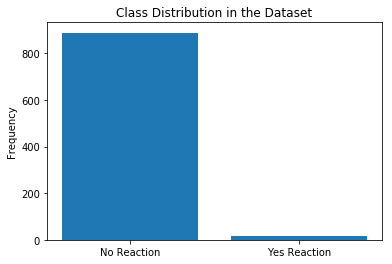

There are 889 negative examples and 15 positive examples in the data set


In [50]:
# Let's look at the distribution of classes present in the data set 

num_positive = sum(full_data_points['Binary Outcome'].values)
num_negative = len(full_data_points['Binary Outcome'].values) - num_positive

classes = ['No Reaction', 'Yes Reaction']
y_pos = np.arange(len(classes))
performance = [num_negative, num_positive]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, classes)
plt.ylabel('Frequency')
plt.title('Class Distribution in the Dataset')

plt.show()

print('There are', int(num_negative), 'negative examples and', int(num_positive), 'positive examples in the data set' )

# Run Data Augmentations

In [9]:
# Perform data augmentations to increase the size of the dataset 
flip_ud = np.zeros(imgs.shape)
flip_lr = np.zeros(imgs.shape) 
rot90 = np.zeros(imgs.shape)
rot180 = np.zeros(imgs.shape)
rot270 = np.zeros(imgs.shape)

for i in range(num_imgs):
    
    if i % 100 == 0: # display progress 
        print(i, 'out of', num_imgs, 'images processed')
    original_img = imgs[:,:,:,i] 
    flip_ud[:,:,:,i] = np.flip(original_img, 0) # flip the image up-down
    flip_lr[:,:,:,i] = np.flip(original_img, 1) # flip the image left-right
    rot90[:,:,:,i] = np.rot90(original_img, 1) # rotate the image 90 degrees 
    rot180[:,:,:,i] = np.rot90(original_img, 2) # rotate the image 180 degrees 
    rot270[:,:,:,i] = np.rot90(original_img, 3) # rotate the image 270 degrees 
    
# Put them all together in one matrix 
aug_imgs = np.concatenate((imgs, flip_ud, flip_lr, rot90, rot180, rot270), axis=3)
aug_labels = np.tile(labels, (6,1)) 

# Verify the shape of the resulting matrix 
print(aug_imgs.shape)
print(aug_labels.shape)

0 out of 16 images processed
(224, 224, 3, 96)
(96, 2)


In [22]:
# save images and labels arrays so we don't have to recompute each time
# np.save('imgs_np_array.npy', aug_imgs)
# np.save('labels_np_array.npy', aug_labels)

# load images and labels arrays 
aug_imgs = np.load('imgs_np_array.npy')
aug_labels = np.load('labels_np_array.npy') 

# Start Training Models

In [23]:
# Split into training, validation, and test sets 
# Note: We have to switch the order of the dimensions of the images so scikit can split it properly 

# Note: This will automatically shuffle the data before splitting it 
# Here we are splitting 70% for training and 20% for testing and 10% for validation 
# We have to use train_test_split twice in order to trick it into splitting off a validation set, too 
imgs_train, imgs_test, labels_train, labels_test = train_test_split(np.rollaxis(aug_imgs, 3), aug_labels, test_size=0.30) 
imgs_test, imgs_val, labels_test, labels_val = train_test_split(imgs_test, labels_test, test_size=0.33) 

In [24]:
# We can check that this worked by checking the size of everything 
print(imgs_train.shape, imgs_val.shape, imgs_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

(3796, 224, 224, 3) (538, 224, 224, 3) (1090, 224, 224, 3)
(3796, 2) (538, 2) (1090, 2)


In [13]:
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
# since we will be testing many models, let's create a function to train, evaluate, and save statistics about each model 
# my_model: the keras model to train
# num_train_layers: the number of final layers to freeze in the network 
def train_model(my_model): 

    # compile the model
    my_model.compile(loss='mean_squared_error',
        optimizer=optimizers.Adam(),
        metrics=['acc'])
    
    # create keras callbacks 
    es = EarlyStopping(monitor='val_loss', patience=2) 
    
    # train the model
    history = my_model.fit(
        imgs_train,
        labels_train, 
        validation_data=(imgs_val,labels_val), 
        batch_size=32, 
        epochs=10, 
        callbacks=[es]
    )
    
    # calculate confusion matrix 
    predictions = my_model.predict(imgs_test)
    plot_confusion_matrix(my_model, labels_test.argmax(axis=1), predictions.argmax(axis=1), ['Yes Reaction', 'No Reaction'])
    
    # save training statistics 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    
    plt.figure()

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(my_model.name + '_accuracy.png') 
    
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(my_model.name + '_loss.png') 
    
    # Evaluate the model 

    # Save the model
    my_model.save(my_model.name + '.h5')

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# This function comes from a scikit example found here: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
def plot_confusion_matrix(model, y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

    np.set_printoptions(precision=2)

In [27]:
vgg16_model = VGG16(weights=None, input_shape=((img_w, img_h, img_ch)), classes=2)
vgg16_model.summary() # let's look at the layers inside this model 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Train on 3796 samples, validate on 538 samples
Epoch 1/10
3796/3796 [==============================] - 32s 8ms/sample - loss: 0.0271 - acc: 0.9729 - val_loss: 0.0242 - val_acc: 0.9758
Epoch 2/10
3796/3796 [==============================] - 29s 8ms/sample - loss: 0.0271 - acc: 0.9729 - val_loss: 0.0242 - val_acc: 0.9758
Epoch 3/10
3796/3796 [==============================] - 31s 8ms/sample - loss: 0.0271 - acc: 0.9729 - val_loss: 0.0242 - val_acc: 0.9758
Epoch 4/10
3796/3796 [==============================] - 29s 8ms/sample - loss: 0.0271 - acc: 0.9729 - val_loss: 0.0242 - val_acc: 0.9758
Confusion matrix, without normalization
[[   0   22]
 [   0 1068]]


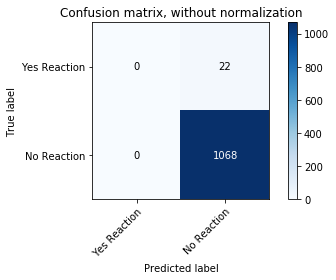

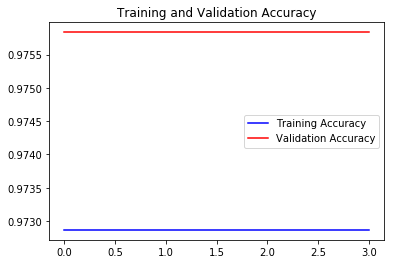

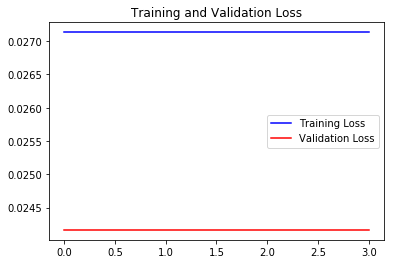

In [30]:
train_model(vgg16_model) 

In [ ]:
vgg16_model = VGG16(weights=None, input_shape=((img_w, img_h, img_ch)), classes=2)
train_model(vgg16_model) 